In [ ]:
!pip install -Uqq fastbook 
import fastbook 
fastbook.setup_book() 

     |████████████████████████████████| 727kB 7.4MB/s 
     |████████████████████████████████| 1.2MB 15.7MB/s 
     |████████████████████████████████| 194kB 36.8MB/s 
     |████████████████████████████████| 51kB 7.0MB/s 
     |████████████████████████████████| 12.8MB 33.6MB/s 
     |████████████████████████████████| 776.8MB 23kB/s 
     |████████████████████████████████| 61kB 9.1MB/s 
     |████████████████████████████████| 51kB 7.4MB/s 
ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.7.1 which is incompatible.
Mounted at /content/gdrive


#Libraries Needed

In [ ]:
from google.colab import drive, files

import re 
import PIL 
import numpy as np 
import torch 
import pandas as pd 
import os 
import gc 
import torchvision.models as models 
from torch.utils.data import Dataset, DataLoader 
from torchvision import transforms 
import seaborn as sns

from fastbook import * 
from fastai.vision.all import * 
from sklearn.metrics import f1_score, confusion_matrix 

In [ ]:
gc.collect()
torch.cuda.empty_cache()

#Unzip 
Unzip the dataset! 

In [ ]:
%%bash 
# unzip /content/gdrive/MyDrive/SpeechRecognition/spectogram.zip
# unzip /content/gdrive/MyDrive/SpeechRecognition/mel_spectrogram.zip

#Paths
Get the pathway to all the images. 

In [ ]:
path_spec = Path('/content/spec/train_images') 
path_mel =  Path('/content/mel_spec/train_images') 

paths = [path_spec,path_mel]

Since, the name for all the test and train files are the same, we can create a common list for all examples, train set, validation set, and test set. 

The function below, `total_values`, is used to get all the relative paths of each file and the number of categories. 

`total_files`: The variable holds the relative path of each file i.e.  `parent_file_name/file_name.jpg` 
`cats`: The variable holds the different catergorical names. 

In [ ]:
def total_values(train_audio): 
  sum, cats = 0, os.listdir(train_audio)
  print(f'Total number of categories is {len(cats)}')

  audio = []

  for cat in cats:
    if cat != '_background_noise_':
      pth = os.path.join(train_audio, cat)
      files = [os.path.join(cat, f) for f in os.listdir(pth)]
      audio.append(files)
      numbs = len(files)
      print(cat, numbs)
      sum += numbs

  print(f'Total number of examples are {sum}')

  return cats, [j for cat in audio for j in cat]
cats, data = total_values(path_spec)

Total number of categories is 10
off 2357
right 2367
down 2359
go 2372
no 2375
up 2375
stop 2380
yes 2377
on 2367
left 2353
Total number of examples are 23682


#Some Common Functions

Before we begin with the training, I am listing below the common functionalities that are repeated for each model. 

##Get Image Files

Through this function, I will be getting the paths for both Train and Validation dataset. 

I have specifically left out the Test set to have an unseen data that can be run to check the real accuracy of the model. 

In [ ]:
def get_image_files(): 
  return [*train,*val] 

##Get the Label
The label for each audio file is the parent folder it is kept in. However, the issue is how to obtain the name of that folder. 

By `label_func`, I make the process easier for obtaining the label of each audio file using the regular expression `r'([^/]+)/'`



In [ ]:
def label_func(fname): 
  return re.findall(r'([^/]+)/', str(fname))[0]

##Splitting the Dataset 
To test the accuracy of the model during training, I need a validation set. The model will only show the accuracy or error rate on this set. Furthermore, this reduces the chances of overfitting.  

By `split`, I will create two sets: train and validation set. The function returns `True` for all paths to the validation folder and `False` to the train set. 



In [ ]:
def split(fpath): 
  return  fpath in val

##Threshold

Since, the test set in Kaggle has various audio clips that contain white noise or unknown sounds, I need to determine a confidence level in the model. 

This is done by creating the function `thresh` which  will only keep the predictions with confidence levels higher than `n`. 

`preds_max` holds the confidence level of the for each prediction. 

In [ ]:
def thresh(n, pred): 
  preds_thresh = []
  vals = [p > n for p in preds_max]
  for id, v in enumerate(vals):
    if v == True: 
      preds_thresh.append(pred[id])
    else: preds_thresh.append('silence')
  return preds_thresh 

##Confusion Matrix

The `ConfusionMatrix` is a graphical representation of the function `confusion_matrix` by SKLearn on `pred` and `true` i.e. the predicted label and the actual label. 


In [ ]:
def ConfusionMatrix(pred, true):  
  matrix = confusion_matrix(pred, true)

  fig, ax = plt.subplots(figsize=(15, 15))
  ax= plt.subplot()
  sns.heatmap(matrix, annot=True, cmap='Blues',ax = ax, fmt='g');

  ax.set_xlabel('Predicted labels');
  ax.set_ylabel('True labels'); 
  ax.set_title('Confusion Matrix'); 
  ax.xaxis.set_ticklabels(cats, Rotation = 45); 
  ax.yaxis.set_ticklabels(cats, Rotation = 0);

##Decode Predictions

In [ ]:
def get_cats(pred): 
  cats = dls.vocab
  return [cats[i] for i in pred]

In [ ]:
cats.sort()
len(cats)

10

#Reduce the Targets 

In [ ]:
def train_test_val():
  val = pd.read_csv('/content/validation_list.txt').values.flatten()
  val = [f'{v[:-3]}png' for v in val]

  test = pd.read_csv('/content/testing_list.txt').values.flatten()
  test = [f'{t[:-3]}png' for t in test]

  train = [t for t in data if t not in [*test,*val]] 
 
  return train, val, test
train_main, val_main, test_main = train_test_val()

In [ ]:
labels = [label_func(t) for t in data]

train = [f for f in data if f in train_main]
val = [f for f in data if f in val_main]
test = [f for f in data if f in test_main]

In [ ]:
true_test = [label_func(t) for t in test] 

In [ ]:
print(f'The length of the train set is {len(train)}')  
print(f'The length of the validation set is {len(val)}')
print(f'The length of the test set is {len(test)}')  

The length of the train set is 18538
The length of the validation set is 2577
The length of the test set is 2567


#Dataset 
Create a dataloader using Spectrogram, Mel Spectrogram, and MFCC Spectrogram 

Get the images for train, validation and test set!

To do this I will create the `SpectrogramImages` class. This class will take in PILImage class and do certain modifications.

In [ ]:
def create_tensor(img): 
  return tensor(img).permute(2, 0, 1).float()/255.0

In [ ]:
class SpectrogramImages(fastuple):
  def show(self, ctx=None):
    img1,img2, label = self
    if (type(label)!=str): label = cats[label]
    line = img1.new_zeros(img1.shape[0],img1.shape[1],10)
    return show_image(torch.cat(([img1,line,img2]),dim = 2), title = label, ctx = ctx, figsize=(12,8))

In [ ]:
img1 = PILImage.create(paths[0]/train[0])
img2 = PILImage.create(paths[1]/train[0])
label = label_func(train[0])

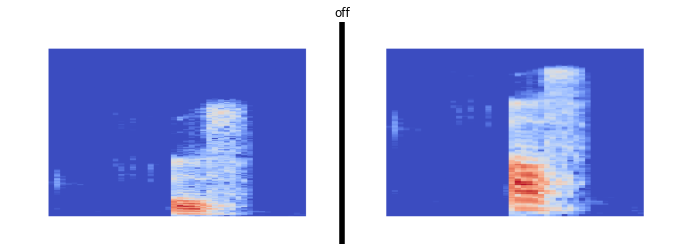

In [ ]:
s = SpectrogramImages(create_tensor(img1), create_tensor(img2), label) 
s.show();

In [ ]:
class SpectogramTransf(Transform): 
  def __init__(self, files, label_func, splits): 
    self.labeller = label_func 
    vals = map(self.labeller, files) 
    self.vocab,self.o2i = uniqueify(vals, sort=True, bidir=True) 
    self.valid = L(files)[splits[1]] 

  def encodes(self, f):
    img1, img2 = PILImage.create(paths[0]/f),PILImage.create(paths[1]/f)
    img1,img2 = img1.crop_pad(sz = (450, 300)), img2.crop_pad(sz = (450, 300))
    return SpectrogramImages(self.create_tensor(img1),self.create_tensor(img2), self.o2i[self.labeller(f)])    

  def create_tensor(self, img): 
    return tensor(img).permute(2, 0, 1).float()/255.0   

In [ ]:
subset_files = get_image_files() 
splits = FuncSplitter(split)(subset_files)

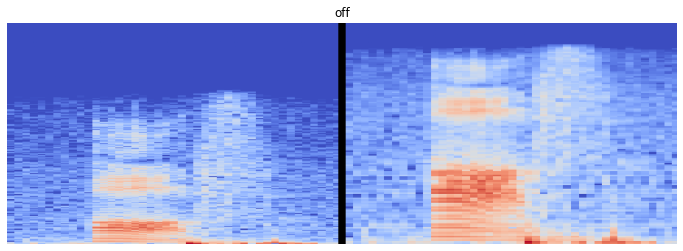

In [ ]:
spec_tfm = SpectogramTransf(subset_files, label_func, splits) 
tls_spec = TfmdLists(subset_files, spec_tfm, splits=splits) 
show_at(tls_spec.valid, 0);  

In [ ]:
bs = 64
dls = tls_spec.dataloaders(after_item=[Resize(224),RandomResizedCrop(256,min_scale=0.05), ToTensor], 
    after_batch=[IntToFloatTensor, Normalize.from_stats(*imagenet_stats)], bs = bs) 

In [ ]:
@typedispatch 
def show_batch(x:SpectrogramImages, y, samples, ctxs=None, max_n=6, nrows=None, ncols=2, figsize=None, **kwargs):
    if figsize is None: figsize = (ncols*6, max_n//ncols * 3) 
    if ctxs is None: ctxs = get_grid(min(x[0].shape[0], max_n), nrows=None, ncols=ncols, figsize=figsize)
    for i,ctx in enumerate(ctxs): SpectrogramImages(x[0][i], x[1][i], cats[x[2][i].item()]).show(ctx=ctx)

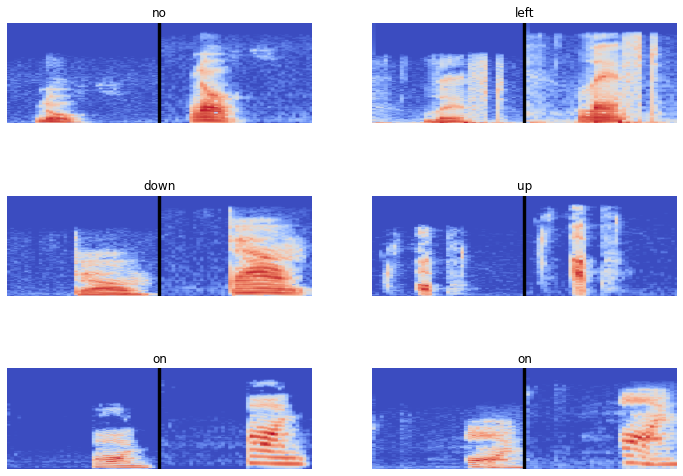

In [ ]:
dls.show_batch(max_n = 6) 

##Test DataLoader

In [ ]:
dls_test = dls.test_dl(test, with_labels=True)

In [ ]:
x1,x2,y = dls.one_batch()

#Create the Model Class

In [ ]:
class SpectrogramModelClass(Module):
  def __init__(self, encoder, head):
    self.encoder,self.head = encoder,head

  def forward(self, x1, x2):
    ftrs = torch.cat([self.encoder(x1), self.encoder(x2)], dim=1)
    return self.head(ftrs)

In [ ]:
body = create_body(resnet34, cut=-2) 
head = create_head(512*2, 10, ps=0.6) 

In [ ]:
model = SpectrogramModelClass(body, head)  

In [ ]:
activs = model(x1.cpu(),x2.cpu()) 

#Loss Function!

In [ ]:
def loss_func(inputs, targets):  
  return nn.BCEWithLogitsLoss()(inputs, F.one_hot(targets, num_classes=10).float()) 

In [ ]:
loss_func(activs.cuda(), y)    

tensor(0.7634, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)

#Split the Model

In [ ]:
def spectrogram_splitter(model):  
  return [params(model.encoder),params(model.head)] 

#Accuracy

In [ ]:
def acc(inp, targ): 
  return (inp == targ).float().mean() 

In [ ]:
def accuracy_multi(inp, targ, thresh=0.5, sigmoid=True):
  targ = F.one_hot(targ, num_classes=10)
  inp,targ = flatten_check(inp,targ)
  if sigmoid: inp = inp.sigmoid() 
  return ((inp>thresh)==targ.bool()).float().mean()

In [ ]:
accuracy_multi(activs, y.cpu()) 

TensorBase(0.5000)

#Train the Classifier!

##ResNet34 Architecture 

In [ ]:
body = create_body(resnet34, cut=-2) 
head = create_head(512*2, 10, ps=0.6) 
model = SpectrogramModelClass(body, head)  

In [ ]:
learn = Learner(dls, model, loss_func=loss_func, splitter=spectrogram_splitter, metrics=accuracy_multi)

In [ ]:
learn.freeze() 

SuggestedLRs(lr_min=0.02089296132326126, lr_steep=0.033113110810518265)

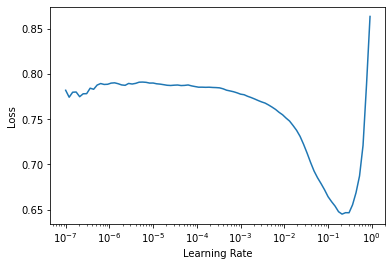

In [ ]:
learn.lr_find() 

In [ ]:
lr = 0.033

In [ ]:
learn.fit_one_cycle(1, 0.033) 

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.049890,0.040501,0.985526,05:15


In [ ]:
learn.save('model-1'); 

In [ ]:
learn.unfreeze() 

SuggestedLRs(lr_min=1.318256749982538e-07, lr_steep=1.5848931980144698e-06)

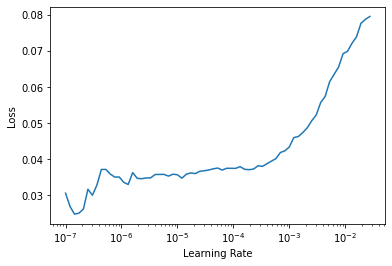

In [ ]:
learn.lr_find() 

In [ ]:
learn.fit_one_cycle(3, slice(1e-6,lr/100)) 

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.034426,0.035500,0.987621,07:15
1,0.030964,0.034276,0.987970,07:15
2,0.030262,0.034207,0.988281,07:15


In [ ]:
learn.export()

##Mini Test Set

In [ ]:
learn_inf = load_learner('/content/FinalModel.pkl') 

In [ ]:
learn_inf.model = learn_inf.model.cuda() #pushing model on GPU 
learn_inf.dls.to('cuda'); #pushing dataset on GPU 

In [ ]:
preds = learn_inf.get_preds(dl = dls_test) 

In [ ]:
preds_prob, preds_ind = torch.max(preds[0], dim = 1)

##Accuracy

In [ ]:
acc(preds_ind, preds[1])

tensor(0.9408)

##Confusion Matrix

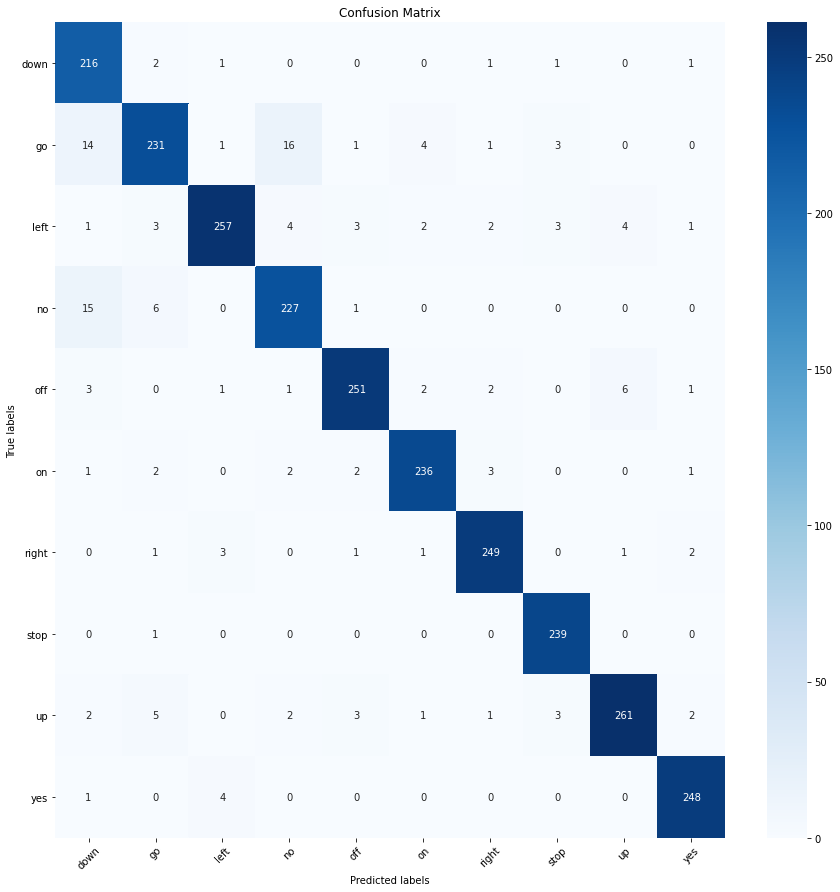

In [ ]:
ConfusionMatrix(preds_ind, preds[1]) 